In [1]:
import pandas as pd
import numpy as np
import keras
from keras import layers
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
sns.set_style()
%matplotlib inline

In [7]:
# Downloading ResNet50 without the top layer
net = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(70,70,3),
    pooling='max',
    classes=15,
    )


94765736/94765736 [==============================] - 5s 0us/step


In [8]:
# Freezing weights of layers in ResNet50
for layer in net.layers:
    layer.trainable = False

In [62]:
# Making data sets from images that are in folders named as their class_label
column_labels = ['blouse', 'dhoti_pants', 'dupattas', 'gowns', 'kurta_men', 'leggings_and_salwars', 'lehenga', 'mojaris_men', 'mojaris_women', 'nehru_jackets', 'palazzos', 'petticoats', 'sherwanis', 'saree', 'women_kurta']

train_dataset = image_dataset_from_directory(
    'data/interim/train_w_labels',
    labels='inferred',
    color_mode='rgb',
    batch_size=256,
    image_size=(70,70),
    shuffle=True,
    seed=None,
    validation_split=None,
    crop_to_aspect_ratio=False,
    class_names=column_labels)

Found 91166 files belonging to 15 classes.


In [63]:
val_dataset = image_dataset_from_directory(
    'data/interim/val_w_labels',
    labels='inferred',
    color_mode='rgb',
    batch_size=256,
    image_size=(70,70),
    shuffle=True,
    seed=None,
    validation_split=None,
    crop_to_aspect_ratio=False,
    class_names=column_labels)

Found 7500 files belonging to 15 classes.


In [14]:
test_dataset = image_dataset_from_directory(
    'data/interim/test_w_labels',
    labels='inferred',
    color_mode='rgb',
    batch_size=256,
    image_size=(70,70),
    shuffle=False,
    seed=None,
    validation_split=None,
    crop_to_aspect_ratio=False,
    class_names=column_labels)

Found 7500 files belonging to 15 classes.


In [15]:
# Normalizing images
normalization_layer = layers.Rescaling(1./255)
train_ds_norm = train_dataset.map(lambda x, y: (normalization_layer(x), y))
test_ds_norm = test_dataset.map(lambda x, y: (normalization_layer(x), y))
val_ds_norm = test_dataset.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
# Setting up model
img_width, img_height = 70,70
epochs = 50
batch_size = 256
n_classes = 15
input_shape= (img_width, img_height, 3)

In [19]:
model = Sequential()

model.add(net)

model.add(Flatten())

model.add(Dense(100, activation='relu'))

model.add(Dropout(.2))

model.add(Dense(15, activation='softmax'))

model.compile(loss='SparseCategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Saving the weights for the lowest loss value
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='/models/resnet.keras',
        save_best_only=True,
        monitor='val_loss'
    )]

In [ ]:
# Running model
history = model.fit(
    x=train_ds_norm,
    y=None,
    validation_data= val_ds_norm,
    epochs=epochs,
    verbose="auto",
    shuffle=True,
    validation_freq=1,
    batch_size = batch_size,
    callbacks=callbacks
    )

Epoch 1/50
357/357 [==============================] - 187s 402ms/step - loss: 0.3261 - accuracy: 0.8994 - val_loss: 0.8709 - val_accuracy: 0.7564
Epoch 2/50
357/357 [==============================] - 145s 400ms/step - loss: 0.2176 - accuracy: 0.9254 - val_loss: 0.7623 - val_accuracy: 0.7895
Epoch 3/50
357/357 [==============================] - 139s 382ms/step - loss: 0.1879 - accuracy: 0.9332 - val_loss: 0.7873 - val_accuracy: 0.7996
Epoch 4/50
357/357 [==============================] - 142s 395ms/step - loss: 0.1792 - accuracy: 0.9355 - val_loss: 0.8134 - val_accuracy: 0.8131
Epoch 5/50
357/357 [==============================] - 140s 388ms/step - loss: 0.1524 - accuracy: 0.9425 - val_loss: 0.9376 - val_accuracy: 0.7825
Epoch 6/50
357/357 [==============================] - 143s 396ms/step - loss: 0.1441 - accuracy: 0.9448 - val_loss: 1.3622 - val_accuracy: 0.7880
Epoch 7/50
357/357 [==============================] - 143s 396ms/step - loss: 0.1359 - accuracy: 0.9474 - val_loss: 0.8941 -

KeyboardInterrupt: ignored

In [ ]:
# Saving model
model.save('/models/resnet.keras')

In [36]:
# Loading the best weights for this model
model.load_weights('models/resnet.keras')
loss, acc = model.evaluate(test_ds_norm, y=None, verbose=2)

30/30 - 5s - loss: 0.7127 - accuracy: 0.8505 - 5s/epoch - 160ms/step


In [37]:
# Un-normalizing the test dataset
test_dataset = test_ds_norm.map(lambda x, y: (255*x, y))

In [38]:
# Getting the images (x_test) and true categories (y_true) from test data set
y_true = []
x_test = []
for x, y in test_dataset:
    y = y.numpy()
    y_true.append(y)
    x_test.append(x)

In [39]:
# Unpacking nested list into 1-D list
y_true = [item for sublist in y_true for item in sublist]

In [40]:
# Unpacking nested list into 1-D list
x_test = [item for sublist in x_test for item in sublist]

In [41]:
# Predicting labels from model
y_pred = model.predict(
    test_ds_norm,
    batch_size=None,
    verbose="auto",
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    )

30/30 [==============================] - 8s 266ms/step


In [42]:
# Since softmax gives probabilities of labels being correct, to get the most likely label,
# must take maximum probability for each label
y_pred = y_pred.argmax(axis=1)

In [43]:
# Calculating metrics
ps = precision_score(y_true, y_pred, average='macro')*100
rs = recall_score(y_true, y_pred, average='macro')*100
f1 = f1_score(y_true, y_pred, average='macro')*100

print(f'Precision: {ps:.2f}')
print(f'Recall: {rs:.2f}')
print(f'F1 Score: {f1:.2f}')

Precision: 85.91
Recall: 85.05
F1 Score: 85.10


In [44]:
# Making a dictionary to take the numerical output and translate it to the class label
label_dict = {0:'blouse', 1:'dhoti_pants', 2:'dupattas', 3:'gowns', 4:'kurta_men', 5:'leggings_and_salwars', 6:'lehenga',
          7:'mojaris_men', 8:'mojaris_women', 9:'nehru_jackets', 10:'palazzos', 11:'petticoats', 12:'sherwanis', 13:'saree',
           14:'women_kurta'}

In [50]:
# Squeezing the np array so that its shape is (70, 70) instead of (70, 70, 1), which is required for Image.fromarray
def tensor_to_image(tensor):
    tensor = np.array(tensor, dtype=np.uint8)
    #tensor = np.squeeze(tensor, axis=2)
    return Image.fromarray(tensor)

## Showing some images and their true and predicted labels.

True label: blouse. Predicted label: blouse


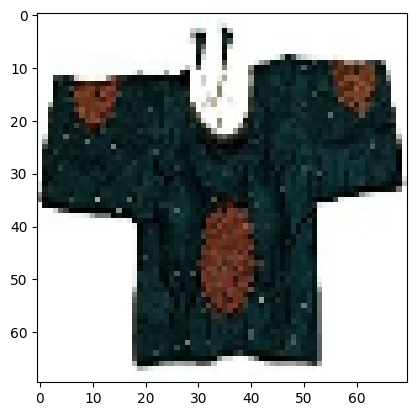

In [51]:
img = tensor_to_image(x_test[1])
plt.imshow(img, cmap='gray')
print(f'True label: {label_dict[y_true[1]]}. Predicted label: {label_dict[y_pred[1]]}')


True label: sherwanis. Predicted label: sherwanis


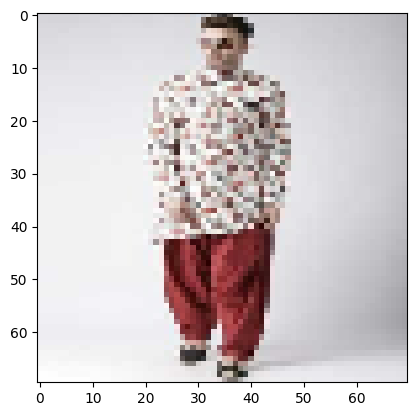

In [52]:
img = tensor_to_image(x_test[6500])
plt.imshow(img, cmap='gray')
print(f'True label: {label_dict[y_true[6500]]}. Predicted label: {label_dict[y_pred[6500]]}')

True label: dupattas. Predicted label: women_kurta


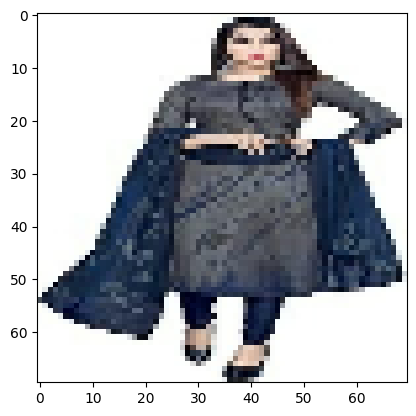

In [53]:
img = tensor_to_image(x_test[1490])
plt.imshow(img, cmap='gray')
print(f'True label: {label_dict[y_true[1490]]}. Predicted label: {label_dict[y_pred[1490]]}')

True label: dupattas. Predicted label: dupattas


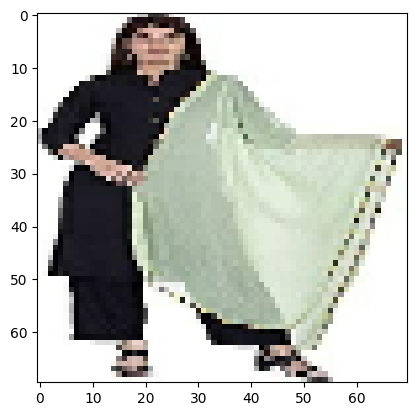

In [54]:
img = tensor_to_image(x_test[1300])
plt.imshow(img, cmap='gray')
print(f'True label: {label_dict[y_true[1300]]}. Predicted label: {label_dict[y_pred[1300]]}')

True label: women_kurta. Predicted label: gowns


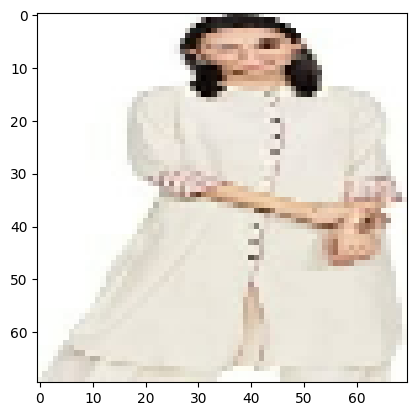

In [55]:
img = tensor_to_image(x_test[7000])
plt.imshow(img, cmap='gray')
print(f'True label: {label_dict[y_true[7000]]}. Predicted label: {label_dict[y_pred[7000]]}')


True label: gowns. Predicted label: gowns


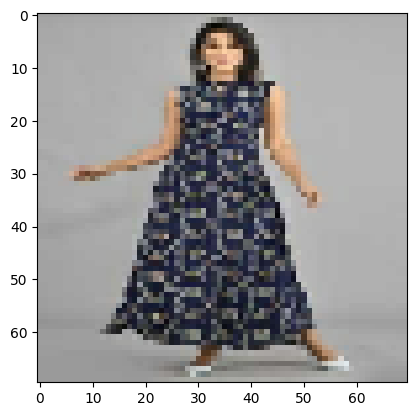

In [56]:
img = tensor_to_image(x_test[1800])
plt.imshow(img, cmap='gray')
print(f'True label: {label_dict[y_true[1800]]}. Predicted label: {label_dict[y_pred[1800]]}')

True label: saree. Predicted label: saree


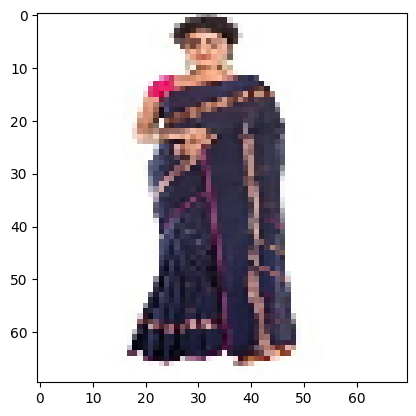

In [57]:
img = tensor_to_image(x_test[6000])
plt.imshow(img, cmap='gray')
print(f'True label: {label_dict[y_true[6000]]}. Predicted label: {label_dict[y_pred[6000]]}')

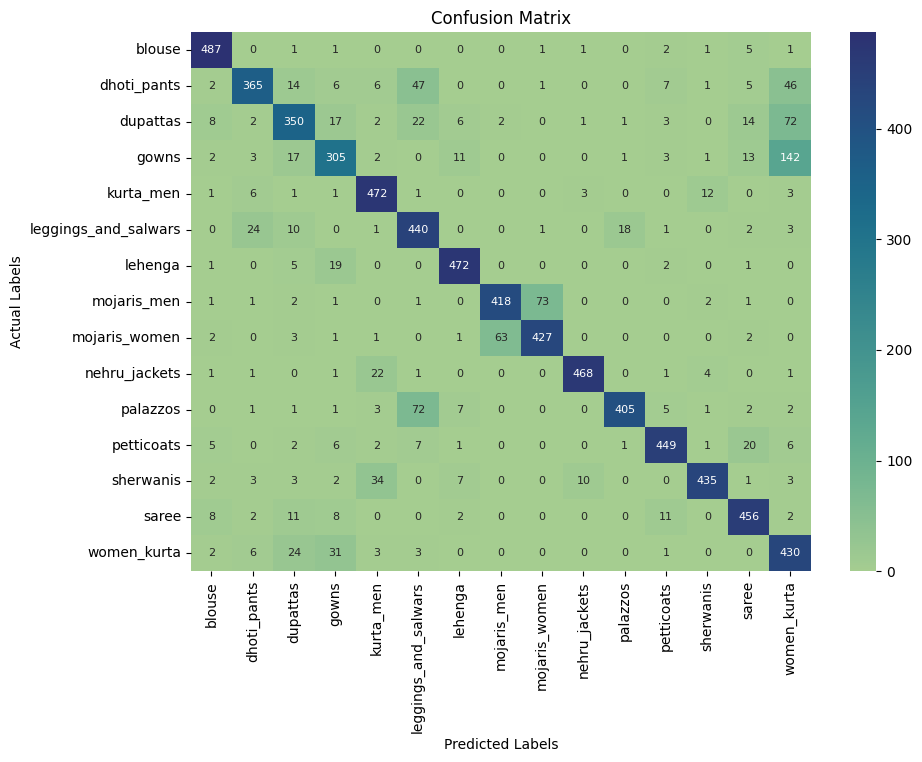

In [58]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting confusion matrix as heat map so that it is easier to read
df_cm = pd.DataFrame(cm, index = ['blouse', 'dhoti_pants', 'dupattas', 'gowns', 'kurta_men', 'leggings_and_salwars', 'lehenga', 'mojaris_men', 'mojaris_women', 'nehru_jackets', 'palazzos', 'petticoats', 'sherwanis', 'saree', 'women_kurta'],
                  columns = ['blouse', 'dhoti_pants', 'dupattas', 'gowns', 'kurta_men', 'leggings_and_salwars', 'lehenga', 'mojaris_men', 'mojaris_women', 'nehru_jackets', 'palazzos', 'petticoats', 'sherwanis', 'saree', 'women_kurta'])
plt.figure(figsize = (10,7))
_ = sns.heatmap(df_cm, annot=True, annot_kws={"size":8}, fmt='d', cmap='crest')
_ = plt.xlabel('Predicted Labels')
_ = plt.ylabel('Actual Labels')
_ = plt.title('Confusion Matrix')